In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
# Reading the data
df = pd.read_csv("spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [26]:
df.shape

(5572, 3)

In [5]:
#drop first row and rename columns v1 and v2 
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


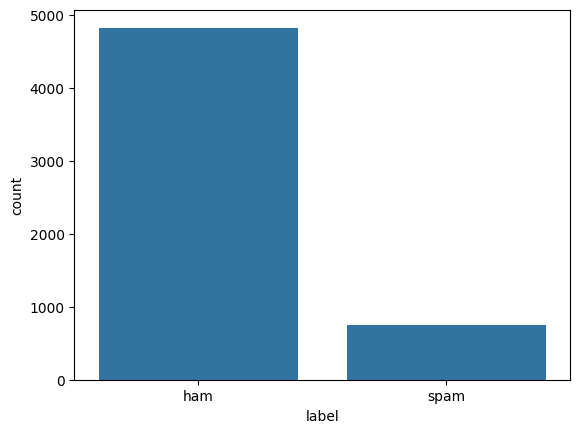

In [6]:
sns.countplot(x=df['label'])
plt.show()

In [7]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)

15


In [8]:
# Finding Total no of unique words in corpus
s = set()
for sent in df['Text']:
  for word in sent.split():
    s.add(word)
total_words_length=len(s)
print(total_words_length)

15585


In [9]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split
 
X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
    new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score
 
tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)
 
baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)

MultinomialNB()

In [11]:
nb_accuracy = accuracy_score(y_test, baseline_model.predict(X_test_vec))
print(nb_accuracy)
print(classification_report(y_test, baseline_model.predict(X_test_vec)))

0.9623318385650225
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



In [12]:
import sklearn
print(sklearn.__version__)

1.4.1.post1


In [13]:
from sklearn.metrics import confusion_matrix
# Assuming baseline_model is your trained model
# Make predictions on the test data
y_pred = baseline_model.predict(X_test_vec)

# Now calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[965,   0],
       [ 42, 108]])

In [14]:
from tensorflow.keras.layers import TextVectorization
 
MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len
 
text_vec = TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)

2024-02-18 20:58:16.640396: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/lib::/usr/local/pgplot/:/usr/local/pgplot/:/usr/local/pgplot/:/usr/local/pgplot/
2024-02-18 20:58:16.640433: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-02-18 20:58:16.640467: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost.localdomain): /proc/driver/nvidia/version does not exist
2024-02-18 20:58:16.641501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appr

In [15]:
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

In [16]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)
 
model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
    label_smoothing=0.5), metrics=['accuracy'])

In [17]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128  

In [18]:
history_1 = model_1.fit(X_train, y_train, epochs= 5, validation_data = (X_test, y_test), 
                        validation_steps = int(0.2*len(X_test)))

Epoch 1/5
140/140 [==============================] - 5s 34ms/step - loss: 0.6057 - accuracy: 0.9138 - val_loss: 0.5768 - val_accuracy: 0.9722
Epoch 2/5
140/140 [==============================] - 4s 30ms/step - loss: 0.5704 - accuracy: 0.9865 - val_loss: 0.5742 - val_accuracy: 0.9803
Epoch 3/5
140/140 [==============================] - 4s 27ms/step - loss: 0.5660 - accuracy: 0.9946 - val_loss: 0.5726 - val_accuracy: 0.9839
Epoch 4/5
140/140 [==============================] - 4s 26ms/step - loss: 0.5644 - accuracy: 0.9982 - val_loss: 0.5728 - val_accuracy: 0.9830
Epoch 5/5
140/140 [==============================] - 4s 25ms/step - loss: 0.5635 - accuracy: 0.9989 - val_loss: 0.5725 - val_accuracy: 0.9794


<AxesSubplot: >

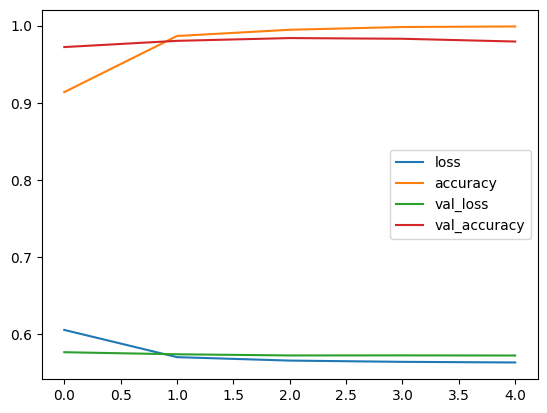

In [19]:
pd.DataFrame(history_1.history).plot()

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score
 
def compile_model(model):
    '''
    simply compile the model with adam optimzer
    '''
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
 
def fit_model(model, epochs, X_train=X_train, y_train=y_train,
              X_test=X_test, y_test=y_test):
    '''
    fit the model with given epochs, train 
    and test data
    '''
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        validation_steps=int(0.2*len(X_test)))
    return history
 
def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy, 
    precision, recall and f1-score 
    '''
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)
 
    model_results_dict = {'accuracy': accuracy,
                          'precision': precision,
                          'recall': recall,
                          'f1-score': f1}
 
    return model_results_dict

In [21]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
    64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)
 
compile_model(model_2)  # compile the model
history_2 = fit_model(model_2, epochs=5)  # fit the model

Epoch 1/5
140/140 [==============================] - 12s 50ms/step - loss: 0.0575 - accuracy: 0.9760 - val_loss: 0.1057 - val_accuracy: 0.9821
Epoch 2/5
140/140 [==============================] - 6s 44ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.1119 - val_accuracy: 0.9803
Epoch 3/5
140/140 [==============================] - 6s 45ms/step - loss: 0.0077 - accuracy: 0.9991 - val_loss: 0.1179 - val_accuracy: 0.9785
Epoch 4/5
140/140 [==============================] - 7s 49ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.1272 - val_accuracy: 0.9812
Epoch 5/5
140/140 [==============================] - 7s 46ms/step - loss: 4.2322e-05 - accuracy: 1.0000 - val_loss: 0.1326 - val_accuracy: 0.9812


In [22]:
import tensorflow_hub as hub
 
# model with Sequential api
model_3 = keras.Sequential()
 
# universal-sentence-encoder layer 
# directly from tfhub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable=False,
                           input_shape=[],
                           dtype=tf.string,
                           name='USE')
model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation=keras.activations.relu))
model_3.add(layers.Dense(1, activation=keras.activations.sigmoid))
 
compile_model(model_3)
 
history_3 = fit_model(model_3, epochs=5)

Epoch 1/5
140/140 [==============================] - 5s 19ms/step - loss: 0.2735 - accuracy: 0.9269 - val_loss: 0.1099 - val_accuracy: 0.9677
Epoch 2/5
140/140 [==============================] - 3s 20ms/step - loss: 0.0776 - accuracy: 0.9796 - val_loss: 0.0702 - val_accuracy: 0.9767
Epoch 3/5
140/140 [==============================] - 4s 31ms/step - loss: 0.0571 - accuracy: 0.9821 - val_loss: 0.0593 - val_accuracy: 0.9812
Epoch 4/5
140/140 [==============================] - 5s 33ms/step - loss: 0.0470 - accuracy: 0.9845 - val_loss: 0.0548 - val_accuracy: 0.9821
Epoch 5/5
140/140 [==============================] - 2s 15ms/step - loss: 0.0393 - accuracy: 0.9877 - val_loss: 0.0525 - val_accuracy: 0.9821


In [23]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
model_3_results = evaluate_model(model_3, X_test, y_test)
 
total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
                             'Custom-Vec-Embedding Model':model_1_results,
                             'Bidirectional-LSTM Model':model_2_results,
                             'USE-Transfer learning Model':model_3_results}).transpose()
 
total_results

35/35 [==============================] - 1s 8ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.981166,0.957447,0.900000,0.927835
Bidirectional-LSTM Model,0.981166,0.957447,0.900000,0.927835
USE-Transfer learning Model,0.982063,0.957746,0.906667,0.931507


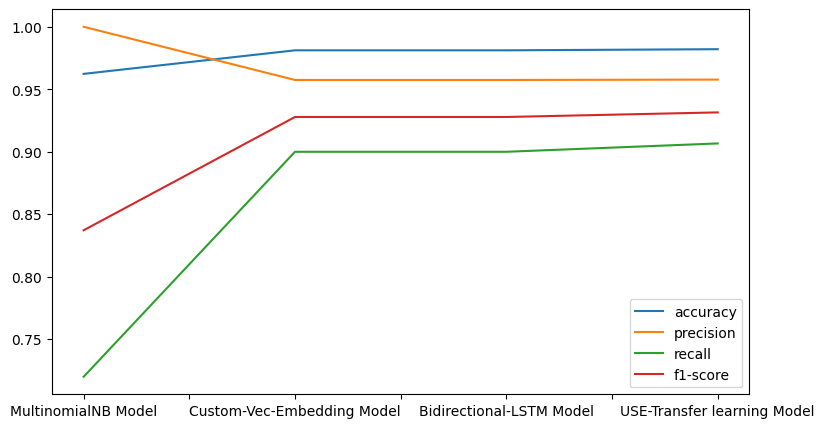

In [34]:
plot = total_results.plot(figsize=(9, 5))